<a href="https://colab.research.google.com/github/navyaveepuru/AI4EO_final_project/blob/main/AI4EO_final_project_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Detecting inland water bodies using AI

This notebook tests the accuracy and precision of supervised (logistic regression and random forest) and unsupervised (K means classification) machine learning techniques for identifying the extent of water distribution within Bangladesh. This location has been chosen due to the abundance of seasonal water bodies and the fact that Bangladesh benefits from this analysis as it is strongly affected by more frequent flooding due to rising sea levels. This creates a demand for water classification for disaster mitigation efforts.

We are using Sentinel-2 satellite data due to its very high resolution and relatively frequent revisit time of 5 days. We use the RGB bands within the satellite data (B4 (Red), B3 (Green), B2 (Blue)) in order to effectively visualise the data without using all the bands as that would be much more computationally expensive.

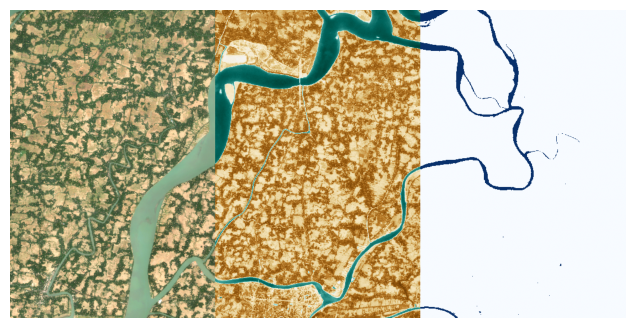

We are using a different region of Bangladesh for the testing and training data, in order to make sure the models are being tested on an unseen region. Both regions have been chosen due to the prescence of low-lying rivers with multiple tributaries and floodplains, as these rural areas are at the highest risk due to both increased hazard (of flooding the floodplains) and increased risk (as rural communities in Bangaldesh tend to have a lower resilience and less robust evacuation procedures).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# set to google drive folder location
folder_name = 'Final Project v3'
base_path = '/content/drive/MyDrive/ucl/AI4EO/'+folder_name+'/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 73.5 MB/s eta 0:00:00


In [4]:
## dependencies

import ee
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import joblib
from joblib import dump
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

## Use Google Earth Engine to export maps for the training and testing data

We are using Google Earth Engine to import the Sentinel-2 (S2) data.

We are using the Normalised Difference Water Index (NDWI) of the S2 data to give us an indication for the 'correct' classification of inland water bodies. The NDWI is a remote sensing technique calculated by finding the normalised difference between near-infrared and green bands (in the S2 data these are the B8 and B3 bands respectively) to find open water surfaces. This works because water strongly reflects green light and absorbs NIR.

NDWI = (Green - NIR) / (Green + NIR)

In [5]:
# authenticate and initialise project; need to create a project in personal google earth engine account
ee.Authenticate()
ee.Initialize(project='ai4eo-final')

In [6]:
## generate training data
# define boundary (small region in bangladesh for faster processing)
bangladesh = ee.Geometry.Rectangle([90.2, 22.2, 90.5, 22.5])

# time range and number of images
start_date = datetime(2023, 1, 1)
num_images = 5 # number of images to export
interval_days = 73 # interval between images; since we have 5 images this will cover the span of one year

# remove cloud cover
def mask_s2_clouds(image):
  qa = image.select('QA60')
  cloud_mask = qa.bitwiseAnd(1 << 10).eq(0).And(qa.bitwiseAnd(1 << 11).eq(0))
  return image.updateMask(cloud_mask).divide(10000).copyProperties(image, ["system:time_start"])

# compute NDWI
def compute_ndwi(image):
    green = image.select('B3')
    nir = image.select('B8')
    ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
    return image.addBands(ndwi).select('NDWI')


In [7]:
# loop through time intervals and export 5 TIFs for both satellite data and satellite data with only the NDWI bands
for i in range(num_images):
    date_from = (start_date + timedelta(days=i * interval_days)).strftime('%Y-%m-%d')
    date_to = (start_date + timedelta(days=(i+1) * interval_days)).strftime('%Y-%m-%d')

    # load S2 SR images and make bounding region smaller for faster processing
    s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
        .filterDate(date_from, date_to) \
        .filterBounds(bangladesh) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .map(mask_s2_clouds)

    # use median composite for that date range
    satellite_image = s2.median().clip(bangladesh) # find the satellite image
    ndwi_image = compute_ndwi(satellite_image) # compute the image with only NDWI bands to make more accurate training masks

    # export to google drive
    task = ee.batch.Export.image.toDrive(
        image=satellite_image,
        description=f'S2_Bangladesh_{i+1}',
        folder=folder_name, # make sure this saves to the correct folder within your Google Drive
        fileNamePrefix=f'S2_bangladesh_{i+1}',
        region=bangladesh,
        scale=30,
        maxPixels=1e13
    )
    task2 = ee.batch.Export.image.toDrive(
        image=ndwi_image,
        description=f'NDWI_Bangladesh_{i+1}',
        folder=folder_name, # make sure this saves to the correct folder within your Google Drive
        fileNamePrefix=f'ndwi_bangladesh_{i+1}',
        region=bangladesh,
        scale=30,
        maxPixels=1e13
    )
    task.start()
    task2.start()
    print(f'Export started for images {i+1} from {date_from} to {date_to}')

Export started for images 1 from 2023-01-01 to 2023-03-15
Export started for images 2 from 2023-03-15 to 2023-05-27
Export started for images 3 from 2023-05-27 to 2023-08-08
Export started for images 4 from 2023-08-08 to 2023-10-20
Export started for images 5 from 2023-10-20 to 2024-01-01


In [8]:
satellite_arr = []
satellite_meta_arr = []
ndwi_arr = []
ndwi_meta_arr = []

for i in range(1,6):
  with rasterio.open(base_path+'ndwi_bangladesh_'+str(i)+'.tif') as src:
          ndwi_arr.append(src.read(src.count).astype('float32'))
          ndwi_meta_arr.append(src.meta.copy())

  with rasterio.open(base_path+'S2_bangladesh_'+str(i)+'.tif') as src:
        # Sentinel-2: B4 (Red), B3 (Green), B2 (Blue)
        red = src.read(4)
        green = src.read(3)
        blue = src.read(2)

        rgb = np.stack([red, green, blue], axis=-1)
        rgb = np.clip(rgb / np.percentile(rgb, 98), 0, 1)  # contrast stretching
        satellite_arr.append(rgb)

In [9]:
# create training data masks from the NDWI water detection

ndwi_threshold = 0.1
i=0

for ndwi in ndwi_arr:

  i=i+1

  meta = ndwi_meta_arr[i-1]

  # create binary water mask
  water_mask = (ndwi > ndwi_threshold).astype('uint8')

  # save mask
  mask_path = base_path+str(i)+'_training_mask.tif'

  meta.update(dtype='uint8')
  with rasterio.open(mask_path, 'w', **meta) as dst:
      dst.write(water_mask, 1)

  print(f"Water mask saved to {mask_path}")

Water mask saved to /content/drive/MyDrive/ucl/AI4EO/Final Project v3/1_training_mask.tif
Water mask saved to /content/drive/MyDrive/ucl/AI4EO/Final Project v3/2_training_mask.tif
Water mask saved to /content/drive/MyDrive/ucl/AI4EO/Final Project v3/3_training_mask.tif
Water mask saved to /content/drive/MyDrive/ucl/AI4EO/Final Project v3/4_training_mask.tif
Water mask saved to /content/drive/MyDrive/ucl/AI4EO/Final Project v3/5_training_mask.tif


In [10]:
water_mask_arr = []
water_mask_arr_meta = []

for i in range(1,6):
  with rasterio.open(base_path+str(i)+'_training_mask.tif') as src:
          water_mask_arr.append(src.read(src.count).astype('float32'))
          water_mask_arr_meta.append(src.meta.copy())

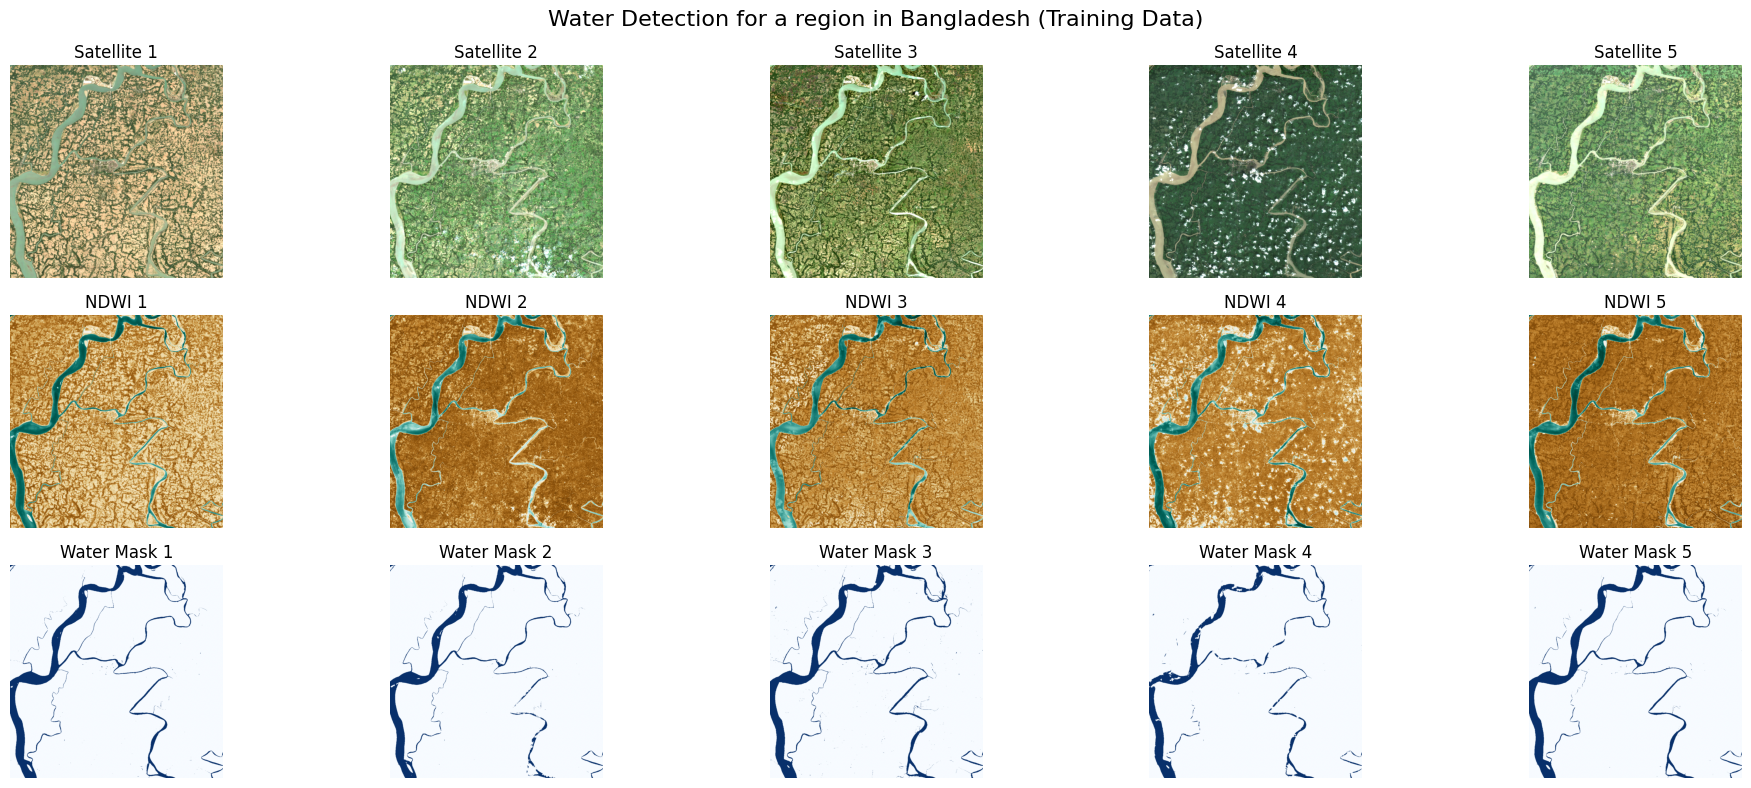

In [14]:
# plot the training data (satellite maps, NDWI maps and water masks)

fig, axes = plt.subplots(3, 5, figsize=(20, 8))  # 3 rows, 5 columns

# Plot Satellite images (row 0)
for i in range(5):
    axes[0, i].imshow(satellite_arr[i])
    axes[0, i].set_title(f'Satellite {i+1}')
    axes[0, i].axis('off')

# Plot NDWI images (row 1)
for i in range(5):
    axes[1, i].imshow(ndwi_arr[i], cmap='BrBG')
    axes[1, i].set_title(f'NDWI {i+1}')
    axes[1, i].axis('off')

# Plot Water masks (row 2)
for i in range(5):
    axes[2, i].imshow(water_mask_arr[i], cmap='Blues')
    axes[2, i].set_title(f'Water Mask {i+1}')
    axes[2, i].axis('off')

plt.suptitle('Water Detection for a region in Bangladesh (Training Data)', fontsize=16)
plt.tight_layout()
plt.show()

The training data highlights the seasonality of water in Bangladesh, with some of the tributaries disappearing in Image 4 of the water masks, and the NDWI images showing how small ponds appear and disappear throughout the year, and how the width of the main channel changes. This shows how risk increases at certain times throughout the year, and how areas like this would be strongly impacted by sea level rise, increased precipitation, and monsoons.

In [15]:
## generate testing data
# export an image in a different region to test the models

bangladesh_test = ee.Geometry.Rectangle([89.35, 21.95, 89.55, 22.15])

date_from = (start_date + timedelta(days=0)).strftime('%Y-%m-%d')
date_to = (start_date + timedelta(days=(50))).strftime('%Y-%m-%d')

# load S2 SR images and make bounding region smaller for faster processing
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterDate(date_from, date_to) \
    .filterBounds(bangladesh_test) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .map(mask_s2_clouds)

# use median composite for that date range
satellite_image = s2.median().clip(bangladesh_test)
ndwi_image = compute_ndwi(satellite_image)

# export to google drive
task = ee.batch.Export.image.toDrive(
    image=satellite_image,
    description=f'Test_Region',
    folder=folder_name,
    fileNamePrefix=f'satellite_test_area',
    region=bangladesh_test,
    scale=30,
    maxPixels=1e13
)
task2 = ee.batch.Export.image.toDrive(
    image=ndwi_image,
    description=f'Test_Region',
    folder=folder_name,
    fileNamePrefix=f'ndwi_test_area',
    region=bangladesh_test,
    scale=30,
    maxPixels=1e13
)
task.start()
task2.start()
print(f'Export started for test region from {date_from} to {date_to}')

Export started for test region from 2023-01-01 to 2023-02-20


In [27]:
with rasterio.open(base_path+'ndwi_test_area.tif') as src:
  ndwi_test_region_image = src.read(src.count).astype('float32')
  ndwi_test_region_meta = src.meta.copy()

with rasterio.open(base_path+'satellite_test_area.tif') as src:
  # Sentinel-2: B4 (Red), B3 (Green), B2 (Blue)
  test_red = src.read(4)
  test_green = src.read(3)
  test_blue = src.read(2)

  test_rgb = np.stack([test_red, test_green, test_blue], axis=-1)
  test_rgb = np.clip(test_rgb / np.percentile(test_rgb, 98), 0, 1)  # contrast stretching

In [28]:
# create a 'correct' mask from the NDWI image for the testing data that we can use to evaluate how accurate our models are

correct_mask_test = (ndwi_test_region_image > ndwi_threshold).astype('uint8')

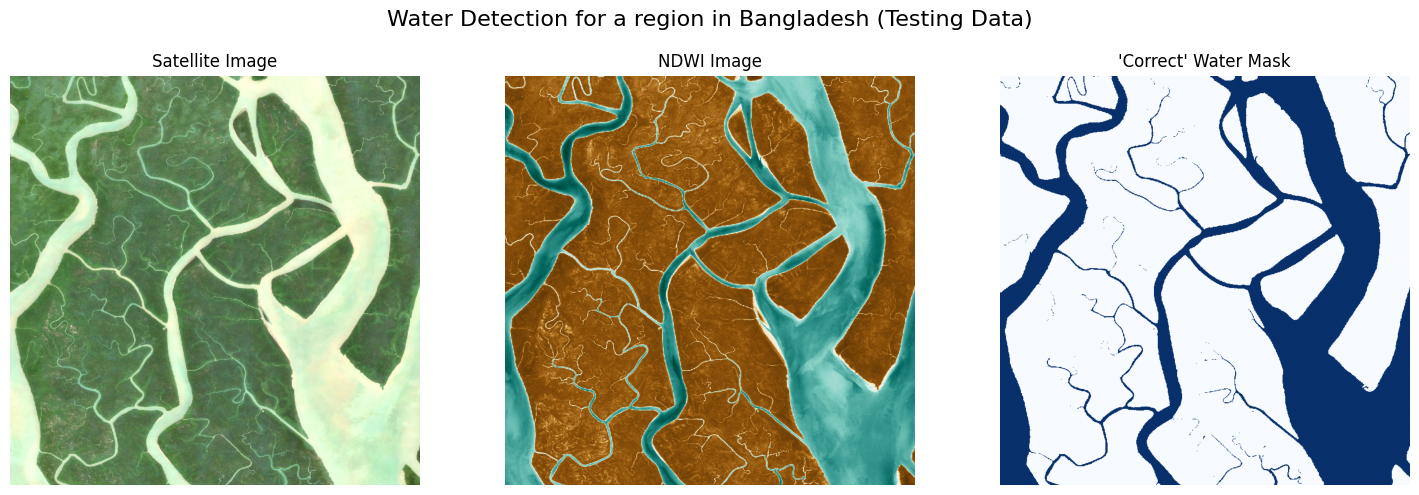

In [29]:
# plot the testing data (satellite map, NDWI map and 'correct' water mask that the models are trying to achieve)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Column 1: Satellite image
axes[0].imshow(test_rgb)
axes[0].set_title('Satellite Image')
axes[0].axis('off')

# Column 2: NDWI image
axes[1].imshow(ndwi_test_region_image, cmap='BrBG')
axes[1].set_title('NDWI Image')
axes[1].axis('off')

# Column 3: Water mask
axes[2].imshow(correct_mask_test, cmap='Blues')
axes[2].set_title("'Correct' Water Mask")
axes[2].axis('off')

plt.suptitle('Water Detection for a region in Bangladesh (Testing Data)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Preprocess the data for supervised learning techniques

Supervised learning techniques such as logistic regression and random forest require careful data preprocessing to ensure that input features align correctly with labeled outputs. This involves cleaning the data (e.g. removing NaNs), selecting relevant features (such as specific satellite bands), and ensuring all samples have valid labels. Preprocessing enhances model accuracy, consistency, and generalizability. In contrast, unsupervised learning methods like K-means classification do not rely on labeled data and are generally less sensitive to label alignment, but they still benefit from preprocessing to remove noise and scale features, helping the model detect meaningful patterns in the data.

In [30]:
# File paths
tif_files = [base_path + f'S2_bangladesh_{i}.tif' for i in range(1, 6)]
mask_files = [base_path + f'{i}_training_mask.tif' for i in range(1, 6)]

X_all = []
y_all = []

for tif_path, mask_path in zip(tif_files, mask_files):
    with rasterio.open(tif_path) as src:
        img = src.read().astype(np.float32)  # (bands, H, W)
        rgb = img[[3, 2, 1], :, :]  # Use B4, B3, B2 (Red, Green, Blue)

        valid_mask = np.all(rgb > 0, axis=0)  # (H, W)

    bands, h, w = rgb.shape
    rgb_reshaped = np.moveaxis(rgb, 0, -1).reshape(-1, 3)  # (H*W, 3)

    with rasterio.open(mask_path) as msk:
        mask = msk.read(1).flatten()

    valid_mask_flat = valid_mask.flatten()
    final_mask = valid_mask_flat & ((mask == 0) | (mask == 1))

    X_all.append(rgb_reshaped[final_mask])
    y_all.append(mask[final_mask])

# Combine training data
X_train = np.vstack(X_all)
y_train = np.hstack(y_all)

print("Training samples:", X_train.shape[0])
print("Class distribution:", np.bincount(y_train))

Training samples: 6192981
Class distribution: [5739161  453820]


## Supervised learning: Logistic regression

Supervised learning requires the use of labelled data. Our first technique, logistic regression, works by modelling the relationship between input features and a binary outcome using a linear function followed by a sigmoid activation. It learns parameters that best separate the two classes based on training data.

In [31]:
## train logistic regression model
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train, y_train)

# evaluate model on training data
y_pred = lr_model.predict(X_train)
acc = accuracy_score(y_train, y_pred)
print(f"Training accuracy: {acc:.4f}")

# save model
joblib.dump(lr_model, base_path + 'lr_model.pkl')

Training accuracy: 0.9407


['/content/drive/MyDrive/ucl/AI4EO/Final Project v3/lr_model.pkl']

In [32]:
## test logistic regression model

# load test image
with rasterio.open(base_path + 'satellite_test_area.tif') as src:
    img = src.read().astype(np.float32)  # (bands, H, W)
    profile = src.profile
    rgb = img[[3, 2, 1], :, :]  # B4, B3, B2 = RGB
    valid_mask = np.all(rgb > 0, axis=0)

bands, h, w = rgb.shape
rgb_reshaped = np.moveaxis(rgb, 0, -1).reshape(-1, 3)

valid_mask_flat = valid_mask.flatten()
X_test = rgb_reshaped[valid_mask_flat]

# predict water (1) vs non-water (0)
y_pred = np.full(rgb_reshaped.shape[0], np.nan)
y_pred[valid_mask_flat] = lr_model.predict(X_test)
y_pred_mask = y_pred.reshape(h, w)

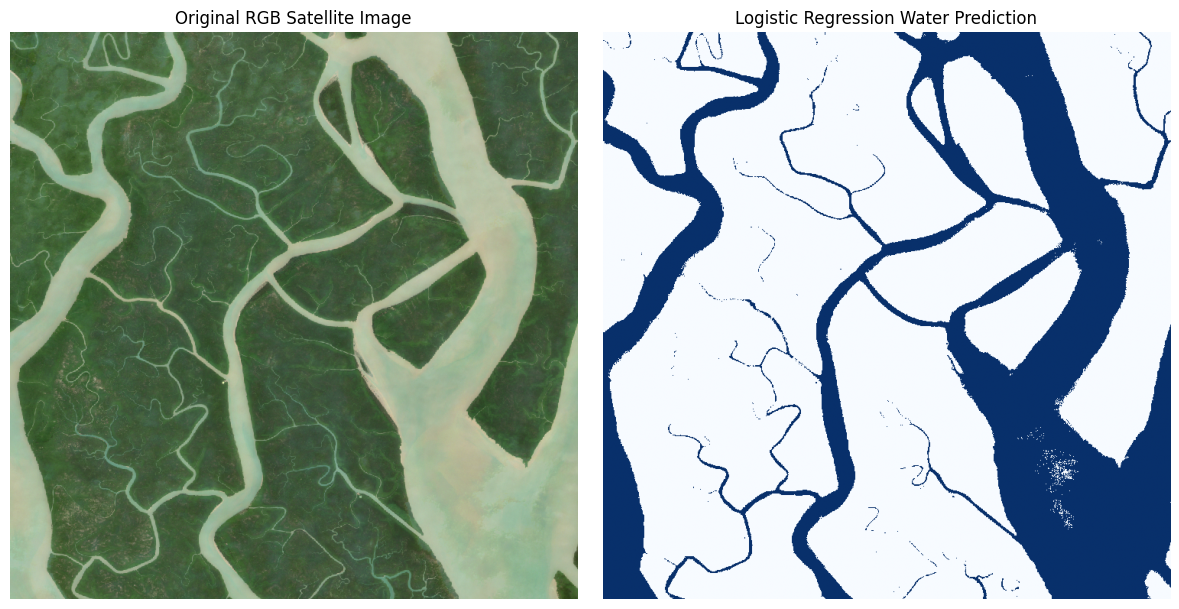

In [33]:
## visualise results

# move RGB to shape (H, W, 3) and normalize if needed
rgb_display = np.moveaxis(rgb, 0, -1)
rgb_display = rgb_display / np.max(rgb_display)  # Normalize to [0, 1] for display

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# original RGB image
axes[0].imshow(rgb_display)
axes[0].set_title("Original RGB Satellite Image")
axes[0].axis('off')

# predicted water mask
axes[1].imshow(y_pred_mask, cmap='Blues')
axes[1].set_title("Logistic Regression Water Prediction")
axes[1].axis('off')

plt.tight_layout()
plt.show()

The result shows that the water mask logistic regression produces looks very similar to the NDWI mask produced earlier. This means it has performed well at the binary classification, as the goal is for the model to produce a model that is as close as possible to the mask based on the NDWI threshold, as that shows that it is very good at applying the necessary transformation on the satellite data that the training data performed.

We can test model performance using a cross-validation score, which works by averaging performance across multiple train-test splits.

We can also test how accurate the model was in predicting the mask for this specific test data by plotting a confusion matrix and accuracy score. The confusion matrix breaks down the predictions vs actual values, so we can see how many pixels were correctly classified and how many were incorrectly classified. The structure of a confusion matrix is as follows:


|                | Predicted Land (0) | Predicted Water (1) |
|----------------|--------------------|----------------------|
| Actual Land (0) | True Negative (TN) | False Positive (FP) |
| Actual Water (1)| False Negative (FN)| True Positive (TP)  |




In [34]:
## cross-validation score

scores = cross_validate(
    lr_model, X_train, y_train,
    cv=5,
    scoring=['accuracy', 'neg_log_loss']
)

print(f"Mean Accuracy (5-fold CV): {scores['test_accuracy'].mean():.4f}")
print(f"Mean Log Loss (5-fold CV): {-scores['test_neg_log_loss'].mean():.4f}")

Mean Accuracy (5-fold CV): 0.8513
Mean Log Loss (5-fold CV): 0.5787


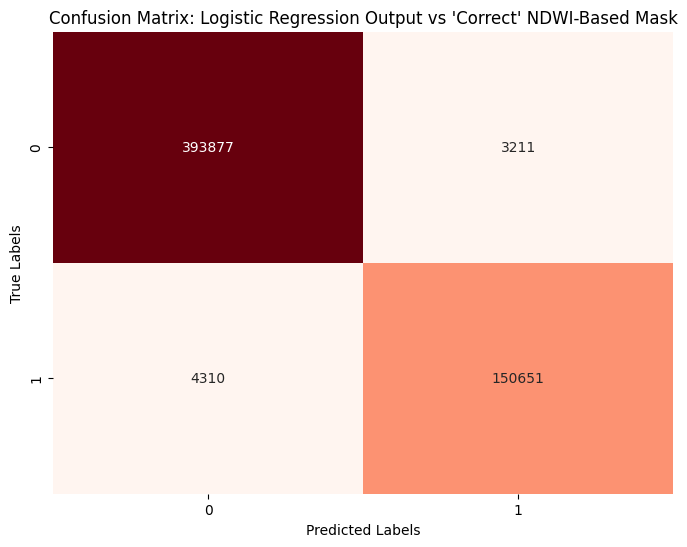

Accuracy: 0.9863762093582272


In [35]:
## confusion matrix and accuracy; comparing to NDWI mask using threshold

# flatten the arrays
correct_baseline = correct_mask_test.flatten()
lr_result = y_pred_mask.flatten()

# confusion matrix
cm = confusion_matrix(correct_baseline, lr_result)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Reds', cbar=False)
plt.title("Confusion Matrix: Logistic Regression Output vs 'Correct' NDWI-Based Mask")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# accuracy
accuracy = accuracy_score(correct_baseline, lr_result)
print('Accuracy: '+str(accuracy))

## Supervised learning: Random forest

Random forest works by building multiple randomized decision trees and aggregating their results to produce an accurate, stable, and generalizable classifier. It aims to reduce overfitting and can handle large, non-linear datasets well.

In [38]:
## train random forest model

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# evaluate model on training data
y_pred = rf_model.predict(X_train)
acc = accuracy_score(y_train, y_pred)
print(f"Training accuracy: {acc:.4f}")

# save the model
dump(rf_model, base_path+'random_forest_model.joblib')
print("Random Forest model saved as random_forest_model.joblib")

Training accuracy: 0.9999
Random Forest model saved as random_forest_model.joblib


In [39]:
## test random forest model

test_tif_path = base_path + 'satellite_test_area.tif'

with rasterio.open(test_tif_path) as src:
    img = src.read().astype(np.float32)
    profile = src.profile
    rgb = img[[3, 2, 1], :, :]
    valid_mask = np.all(rgb > 0, axis=0)

bands, h, w = rgb.shape
rgb_reshaped = np.moveaxis(rgb, 0, -1).reshape(-1, 3)

# Predict
y_pred = np.full(rgb_reshaped.shape[0], np.nan)
valid_idx = np.where(valid_mask.flatten())[0]
y_pred[valid_idx] = rf_model.predict(rgb_reshaped[valid_idx])
rf_y_pred_mask = y_pred.reshape(h, w)

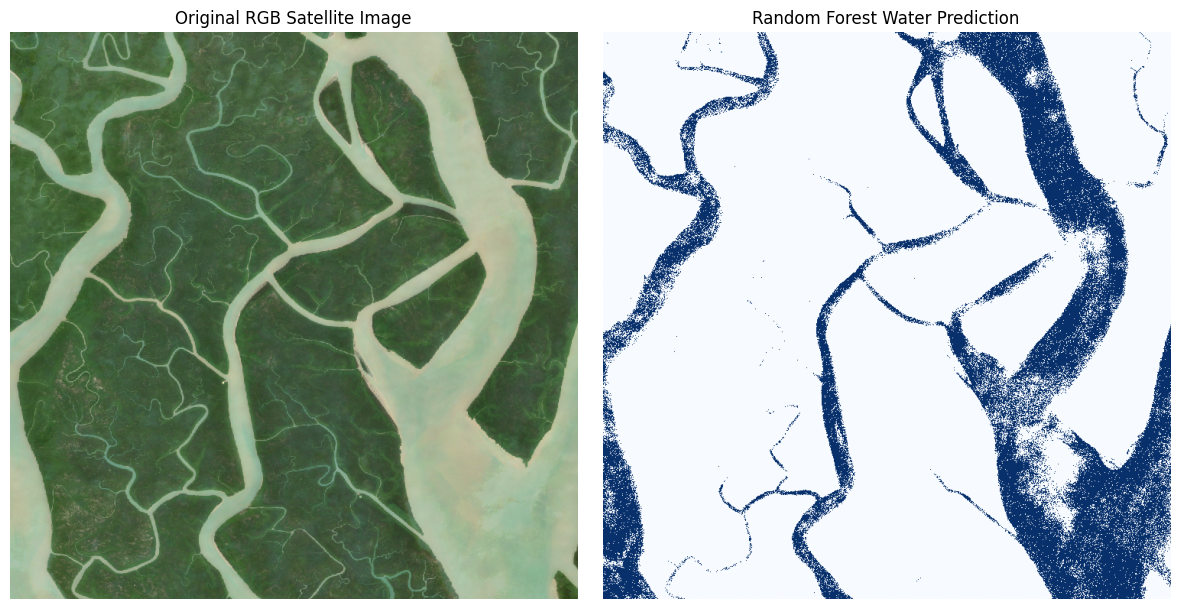

In [40]:
## visualise results

rgb_display = np.moveaxis(rgb, 0, -1)
rgb_display = rgb_display / np.max(rgb_display)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# RGB image
axes[0].imshow(rgb_display)
axes[0].set_title("Original RGB Satellite Image")
axes[0].axis('off')

# Water mask prediction
axes[1].imshow(rf_y_pred_mask, cmap='Blues')
axes[1].set_title("Random Forest Water Prediction")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
## cross validation score

scores2 = cross_validate(
    rf_model, X_train, y_train,
    cv=5,
    scoring=['accuracy', 'neg_log_loss']
)

print(f"Mean Accuracy (5-fold CV): {scores2['test_accuracy'].mean():.4f}")
print(f"Mean Log Loss (5-fold CV): {-scores2['test_neg_log_loss'].mean():.4f}")

Mean Accuracy (5-fold CV): 0.9521
Mean Log Loss (5-fold CV): 0.4944


Random forest recieved an excellent 5 fold cross-validation score of 0.9521 (with a mean log loss of 0.4944). This highlights what a consistent and reliable tool it is. However, it took around 5 times longer than logistic regression for processing, which suggests that it is not ideal for near real-time water detection, which could be useful to Bangladesh in times such as the Monsoon season when water levels can rise quickly.

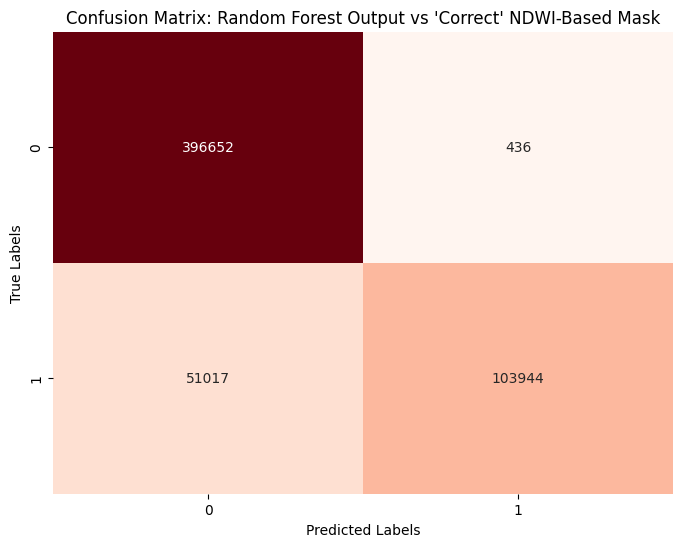

Accuracy: 0.9067963169936002


In [41]:
## confusion matrix and accuracy

rf_result = rf_y_pred_mask.flatten()

cm2 = confusion_matrix(correct_baseline, rf_result)

plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap='Reds', cbar=False)
plt.title("Confusion Matrix: Random Forest Output vs 'Correct' NDWI-Based Mask")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

accuracy2 = accuracy_score(correct_baseline, rf_result)
print('Accuracy: '+str(accuracy2))

## Unsupervised learning: K means classification
Unsupervised learning techniques such as K-means classification do not require the data to be labelled beforehand, so we not need to train the data. It clusters the image into
𝑘 groups without needing labeled training data. For binary classification (in this case, water vs. non-water),
𝑘
=
2 is used. The cluster with lower brightness (darker pixels) is typically interpreted as water. Although simple and fast, K-means may be less accurate than supervised methods, as it doesn't learn from ground truth labels.

In [42]:
## use k-means classification on testing data

# load the satellite image
tif_path = base_path + 'satellite_test_area.tif'
with rasterio.open(tif_path) as src:
    img = src.read()  # shape: (bands, H, W)
    profile = src.profile

# select RGB bands (S2: B4, B3, B2)
rgb_img = img[[3, 2, 1], :, :].astype(np.float32)  # (3, H, W)
bands, h, w = rgb_img.shape

# reshape and filter valid data
img_reshaped = np.moveaxis(rgb_img, 0, -1).reshape(-1, 3)  # (H*W, 3)
valid_mask = np.all(img_reshaped > 0, axis=1)

# Run KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(img_reshaped)

# Compute brightness of each cluster
cluster_brightness = kmeans.cluster_centers_.mean(axis=1)

# Brighter cluster = water → set as 1
water_cluster = np.argmax(cluster_brightness)  # brighter = water

# Create binary mask: 1 = water, 0 = land
water_mask_flat = (labels == water_cluster).astype(int)
water_mask = water_mask_flat.reshape(h, w)

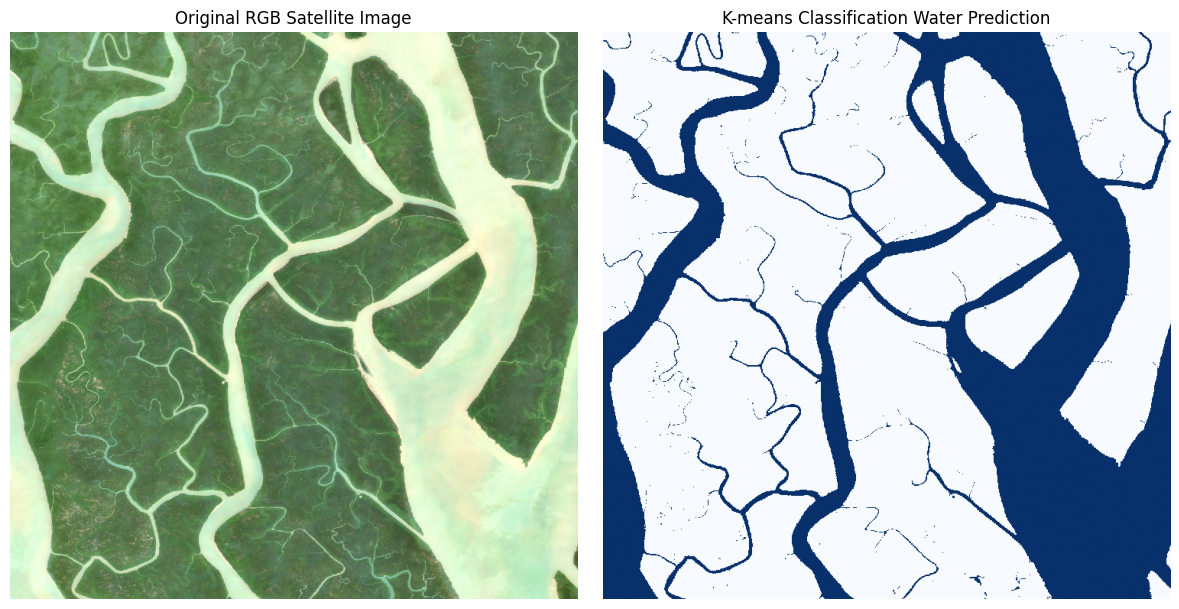

In [43]:
## visualise results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# RGB image
rgb_display = np.moveaxis(rgb_img, 0, -1) / np.percentile(rgb_img, 99)  # normalize for display
axes[0].imshow(np.clip(rgb_display, 0, 1))
axes[0].set_title("Original RGB Satellite Image")
axes[0].axis('off')

# Water mask
axes[1].imshow(water_mask, cmap='Blues')
axes[1].set_title("K-means Classification Water Prediction")
axes[1].axis('off')

plt.tight_layout()
plt.show()

Since K-Means is unsupervised (and doesn't use labels), the cross-validation score is not applicable.

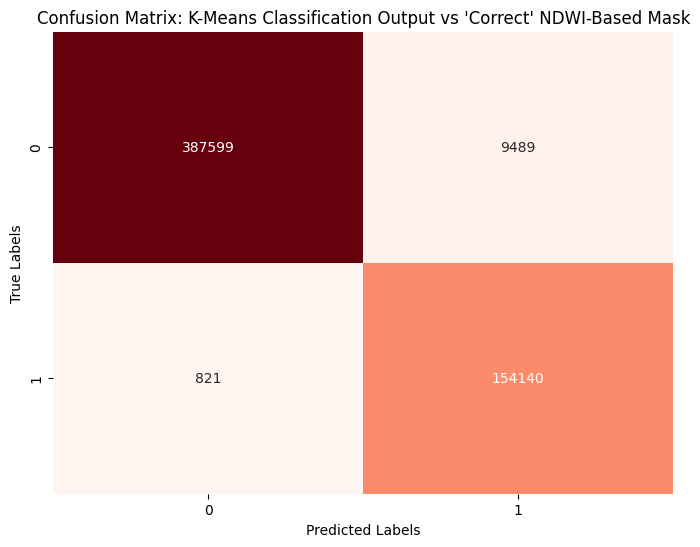

Accuracy: 0.9813241215906559


In [44]:
## confusion matrix and accuracy

kmeans_result = water_mask.flatten()

cm3 = confusion_matrix(correct_baseline, kmeans_result)

plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt="d", cmap='Reds', cbar=False)
plt.title("Confusion Matrix: K-Means Classification Output vs 'Correct' NDWI-Based Mask")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

accuracy3 = accuracy_score(correct_baseline, kmeans_result)
print('Accuracy: '+str(accuracy3))

## Conclusions and comparison of models



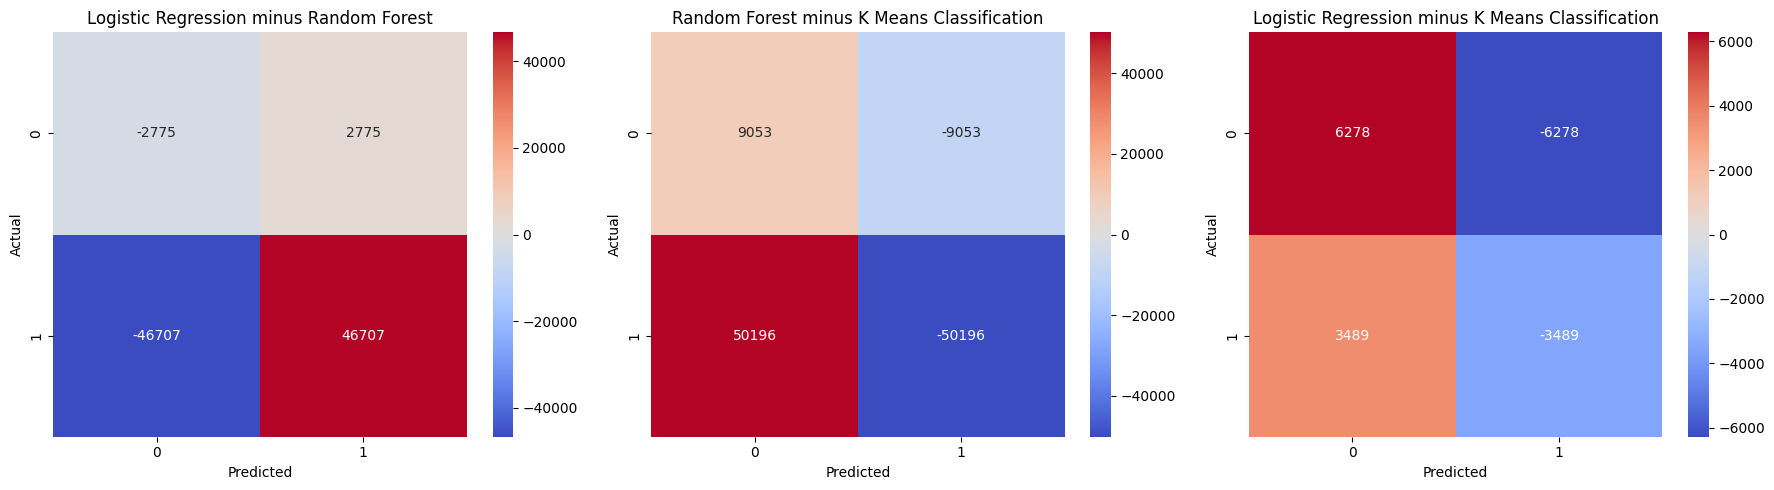

In [45]:
## visualising the difference between the confusion matrices of the 3 models

# Calculate pairwise difference matrices
diff_1_2 = cm - cm2
diff_2_3 = cm2 - cm3
diff_1_3 = cm - cm3

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(diff_1_2, annot=True, fmt='d', cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Logistic Regression minus Random Forest')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(diff_2_3, annot=True, fmt='d', cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title('Random Forest minus K Means Classification')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

sns.heatmap(diff_1_3, annot=True, fmt='d', cmap='coolwarm', center=0, ax=axes[2])
axes[2].set_title('Logistic Regression minus K Means Classification')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

What this shows:

*   Positive numbers (red) mean the first model in the pair made more predictions in that cell.
*   Negative numbers (blue) mean the second model made more predictions.
*   Cells close to zero indicate similar performance between the models.

As a reminder, the structure of a confusion matrix is:


|                | Predicted Land (0) | Predicted Water (1) |
|----------------|--------------------|----------------------|
| Actual Land (0) | True Negative (TN) | False Positive (FP) |
| Actual Water (1)| False Negative (FN)| True Positive (TP)  |



This shows that:

*   Logistic regression made more true negative, and less false positive predictions than random forest
*   Random forest made more false positive and less true negative predictions than k-means
*   Logistic regression made more true positive and less false negative predictions than k-means
*   Logistic regression made slightly more false positive, and slightly less true negative predictions than k-means

Overall, this suggests that random forest underperformed compared to the other models, largely due to the abundance of false negative results. This could be problematic as it could underpredict the severity of flooding in Bangladesh. Therefore, especially during times of increased risk of flooding, such as during Monsoon season, logistic regression is the preferred supervised technique despite its lower 5-fold cross validation accuracy (0.85 compared to 0.95). A lower CV accuracy suggests that the model will not perform as well on real-world, unseen data due to overfitting or underfitting. A higher CV accuracy suggests the model is more consistent and reliable across different datasets. However, the difference in misclassification rate is large enough to justify the use of logistic regression over random forest. Furthermore, random forest had a much higher processing time compared to logistic regression, which limits its usage for near real-time water detection for times when the water levels rise quickly, such as during a flood.

Logistic regression contained more true negatives and less false positives than K-means. This means that when data can be labelled, logistic regression is clearly superior in terms of accuracy and precision. However, K-means was less computationally expensive and did not require the use of labelled data. Therefore, for everyday use, K-means may be preferred to monitor water levels. However, in times where accuracy is very important and labelled data is available (ie. during critical times in hazard mitigation such as the Monsoon season), logistic regression may be preferred to k-means classification.

Overall, all models had relatively high accuracy (above 0.9), but logistic regression and k-means classification were noticeably higher (above 0.98), and are the preferred supervised and unsupervised techniques respectively.



